In [1]:
import pandas as pd
df = pd.read_csv('document.csv')
# print(df)

In [2]:
from io import StringIO
col = ['label', 'text']
df = df[col]
df = df[pd.notnull(df['text'])]
df.columns = ['label', 'text']
df['category_id'] = df['label'].factorize()[0]
category_id_df = df[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)

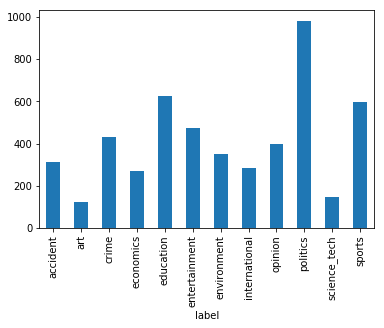

In [3]:
import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(8,6))
df.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.text).toarray()
labels = df.category_id
features.shape

(5000, 34465)

In [5]:
from sklearn.feature_selection import chi2
import numpy as np
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'accident':
  . Most correlated unigrams:
. ঘট
. ঘটন
. আহত
  . Most correlated bigrams:
. ঘট বল
. ঘটন থল
. ঘটন ঘট
# 'art':
  . Most correlated unigrams:
. বইট
. উপন
. গল
  . Most correlated bigrams:
. ঞত এখন
. অভ নয়
. সর ছব
# 'crime':
  . Most correlated unigrams:
. নউজ
. হতઘ
. ওস
  . Most correlated bigrams:
. হত কর
. তদন জন
. হত মল
# 'economics':
  . Most correlated unigrams:
. এসইর
. এসইত
. এসই
  . Most correlated bigrams:
. নদ হয়
. সচ এসই
. টক এক
# 'education':
  . Most correlated unigrams:
. answer
. ii
. iii
  . Most correlated bigrams:
. বহ চন
. ii iii
. রশ তর
# 'entertainment':
  . Most correlated unigrams:
. ০০
. ছব
. চলচ
  . Most correlated bigrams:
. বল উড
. অভ নয
. অভ নয়
# 'environment':
  . Most correlated unigrams:
. জলব
. এনফ
. ড়পত
  . Most correlated bigrams:
. জলব পর
. অধ দপ
. পর অধ
# 'international':
  . Most correlated unigrams:
. ভরভ
. আইএস
. এএফপ
  . Most correlated bigrams:
. পরম অস
. ইউক ইন
. খবর এএফপ
# 'opinion':
  . Most correlated unigrams:
. মত
. মশন
. নবગ


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.20, random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score

models = [
#     LinearSVC(),
#     MultinomialNB(),
#     LogisticRegression(),
#     DecisionTreeClassifier(),
#     KNeighborsClassifier(n_neighbors=4),
    MLPClassifier(activation='tanh', hidden_layer_sizes=(10, 10, 10), max_iter=150)
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

# import seaborn as sns
# sns.boxplot(x='model_name', y='accuracy', data=cv_df)
# sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
#               size=8, jitter=True, edgecolor="gray", linewidth=2)
# plt.show()

In [10]:
cv_df.groupby('model_name').accuracy.mean()

model_name
MLPClassifier    0.654394
Name: accuracy, dtype: float64